In [1]:
__version__ = '2021-06-13'
__authors__ = ['Robert Nikutta <robert.nikutta@gmail.com>', 'Enrique Lopez-Rodriguez', 'Kohei Ichikawa']

# Hypercat - With astronomy in mind
This notebook demonstrates some advanced usage of the HYPERCAT software with CLUMPY models, including physical units, WCS, and pixel operations.

## Disclaimer and Attribution
HYPERCAT / CLUMPY models and the accompanyin software were published in two papers. If you decide to make use of either the models, the software, the example notebooks, or the included pupil images of telescopes included with HYPERCAT, please cite these two papers:

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- I. Models and Image Morphology", ApJ (2021, accepted)**

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- II. Resolving the
torus with Extremely Large Telescopes", ApJ (2021, under review)**


## Table of contents
* [Imports & setup](#import)
* [Physical units](#units)
* [World coordinate system](#wcs)
* [Field of view and pixel scale operations](#pixops)
* [Image rotation](#rot)
* [Save as FITS file](#savefits)
* [Further information](#info)

<a class="anchor" id="import"></a>
## Imports and setup

In [2]:
# std lib
import pprint as P  # for pretty-printing some data sctructures
pprint = P.PrettyPrinter(indent=2,width=200).pprint
import warnings
warnings.filterwarnings("ignore", message="dataset.value has been deprecated")

# 3rd party
from astropy import units as u 
from astropy.io import fits

# own
import hypercat as hc
from hypercat import ioops
from hypercat import plotting
print("HYPERCAT version:",hc.__version__)

HYPERCAT version: 0.1.4


<a class="anchor" id="units"></a>
## Physical units

**Load the model cube**

Let's start by loading the model hypercube again:

In [3]:
fname = 'hypercat_20181031_all.hdf5' # use your local location to the HDF5 model file
cube = hc.ModelCube(fname,hypercube='imgdata')

Opening HDF5 file: hypercat_20181031_all.hdf5 
Loading sampling parameters.
self.theta.shape =  (9,)
Closing HDF5 file.
self.theta_full.shape =  (9,)
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,25,121,241)] to RAM (912.52 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, ...
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 - 160.000]  (  7)    10.000, 20.000,

**Make an astrophysical source (and AGN)**

As we've seen in the notebook 01-hypercat-basic.ipynb you can use this `cube` object to generate raw model images very quickly. Such model images are sufficient to study e.g. their morpholygy, but they do not carry have physical units for either pixel scale or flux.

HYPERCAT allows us to create an abstraction of an astrophysical source (i.e. an AGN) and generate images that carry proper units for pixel scale and brightness values.<br>
This `Source` can also resolve the name of a real source into coordinates, and construct a WCS.<br>
The position angle on the sky (PA) can also be given, with the astronomical convention that positive angles count from N to E (counter-clockwise).

In [4]:
agn = hc.Source(cube,luminosity='1.6e45 erg/s',distance='14.4 Mpc',objectname='ngc1068',pa='43 deg')

Note how quantities with units are given as a single string of the form `'VALUE UNITS'`, e.g. `'1.6e45 erg/s'`, `'14.4 Mpc'`, and `'43 deg'`, i.e. with a single space separation.

All currently understood units are:

In [5]:
pprint(hc.UNITS)

{ 'ANGULAR': ('arcsec', 'mas', 'milliarcsecond', 'deg', 'degree', 'rad', 'radian'),
  'BRIGHTNESS': ('Jy/pix', 'mJy/pix'),
  'CUNITS': ('arcsec', 'mas', 'milliarcsecond', 'deg', 'degree', 'rad', 'radian', 'cm', 'm', 'AU', 'lyr', 'pc', 'kpc', 'Mpc', 'Gpc'),
  'FLUXDENSITY': ('Jy', 'mJy', 'MJy', 'erg/s/cm^2/Hz', 'W/m^2/Hz'),
  'INVERSELINEAR': ('1/cm', '1/m', '1/AU', '1/lyr', '1/pc', '1/kpc', '1/Mpc', '1/Gpc'),
  'LINEAR': ('cm', 'm', 'AU', 'lyr', 'pc', 'kpc', 'Mpc', 'Gpc'),
  'LUMINOSITY': ('erg/s', 'W', 'Lsun', 'solLum'),
  'TEMPERATURE': ('K',),
  'WAVE': ('Angstrom', 'nm', 'micron', 'mm')}


All calculations obey the provided units and transform as needed. Examples:

In [6]:
print("%s = %s = %s" % (agn.distance, agn.distance.to('lyr'), agn.distance.to('km')))
print("%s = %s" % (agn.luminosity, agn.luminosity.to('Lsun')))

14.4 Mpc = 46966518.39121104 lyr = 4.4433757173475685e+20 km
1.6e+45 erg / s = 417972831765.9353 solLum



**Generating images**

We can now generate brightness maps with spatial and flux units just as before by providing a vector of model parameters:

In [7]:
vec = (40,85,20,4,0,20,10.0)  # thes are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]

In [8]:
img = agn(vec,total_flux_density='1.5 Jy')

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
rawimage.min():  0.0
Rotated image (see self.data) by 43.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.


Note how the image carries the units of brightness, `'Jy/pix'`

In [9]:
img.data.unit

Unit("Jy / pix")

and the total flux density can be easily obtained by summing, or via built-in methods:

In [10]:
print(img.data.sum()*u.pix)  # summing
print(img.getTotalFluxDensity())  # built-in function
print(img.F)  # a built-in shortcut

1.5 Jy
1.500000013845256 Jy
1.500000013845256 Jy


<a class="anchor" id="wcs"></a>
## World coordinate system
If `objectname` was given during the creation of the `Source` instance, and the name was resolvable, then a simple WCS was created too, and the model image can be plotted as representing the actual AGN on the sky, here with absolute angular coordinates:

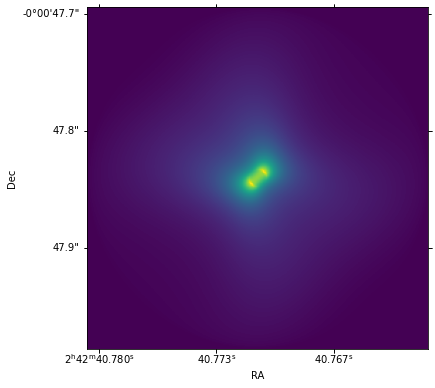

In [11]:
plotting.plot_with_wcs(img)

Or plot with relative angular coordinates:

ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None


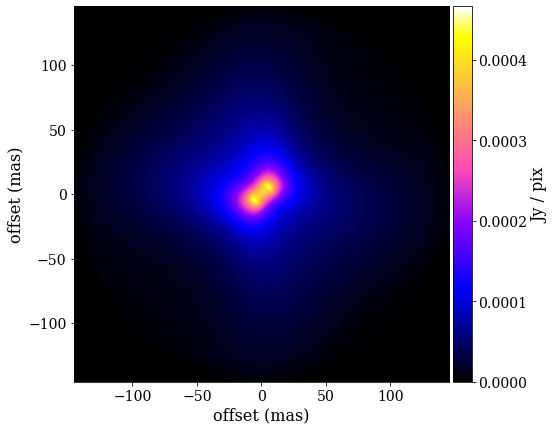

In [12]:
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');

The WCS is accessible:

In [13]:
img.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 40.66987917  -0.01328889  
CRPIX : 121.0  121.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -3.3552808069658016e-07  3.3552808069658016e-07  
NAXIS : 0  0

and one can operate on it for instance with astropy methods:

In [14]:
center_pix = img.data.shape[0] // 2
center = img.wcs.pixel_to_world(center_pix, center_pix) # convert central pixel to RA+Dec
corner = img.wcs.pixel_to_world(0,0)  # convert corner pixel to RA+Dec
print("Angular separation between center and corner of image:", center.separation(corner).to('mas'))

Angular separation between center and corner of image: 204.988mas


<a class="anchor" id="pixops"></a>
## Field of view and pixel scale operations
An image created from a `Source` object has the attributes `.FOV`, `.pixelscale`, and `.pixelarea`, as well as methods to operate on them. They can be used to e.g. set the field of view of an image:

In [15]:
def diagnostics(img):
    template = "%s = %s"
    print("-----------")
    print(template % ('npix',img.npix))
    print(template % ('pixelscale',img.pixelscale))
    print(template % ('FOV',img.FOV))
    print(template % ('total flux density',img.getTotalFluxDensity()))
    print("-----------")
    print()

In [16]:
diagnostics(img)

-----------
npix = 241
pixelscale = 1.2079010905076883 mas
FOV = 291.1041628123529 mas
total flux density = 1.500000013845256 Jy
-----------



Let's check that FOV = number of pixels times pixelscale

In [17]:
img.npix * img.pixelscale

<Quantity 291.10416281 mas>

**Change pixelscale and FOV**

We can also change the field of view and/or pixelscale by assignment (i.e. the image pixels won't change, only the scales):

In [18]:
diagnostics(img)

-----------
npix = 241
pixelscale = 1.2079010905076883 mas
FOV = 291.1041628123529 mas
total flux density = 1.500000013845256 Jy
-----------



In [19]:
img.setPixelscale('0.9 mas')
diagnostics(img)

-----------
npix = 241
pixelscale = 0.9 mas
FOV = 216.9 mas
total flux density = 1.500000071525574 Jy
-----------



Note how the changed pixel scale affected the FOV, but the number of pixels along each axis and the total flux density remained the same.

**Embed and crop**

We can also zoom in our out by enlarging or shrinking the FOV, this time by either embedding the image in a larger pixel array, or by cropping the image array.

Let's try a zoom-out (larger array) first:

BEFORE
-----------
npix = 241
pixelscale = 0.9 mas
FOV = 216.9 mas
total flux density = 1.500000071525574 Jy
-----------

ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None
AFTER
-----------
npix = 667
pixelscale = 0.9 mas
FOV = 600.3000000000001 mas
total flux density = 1.4999999749660493 Jy
-----------



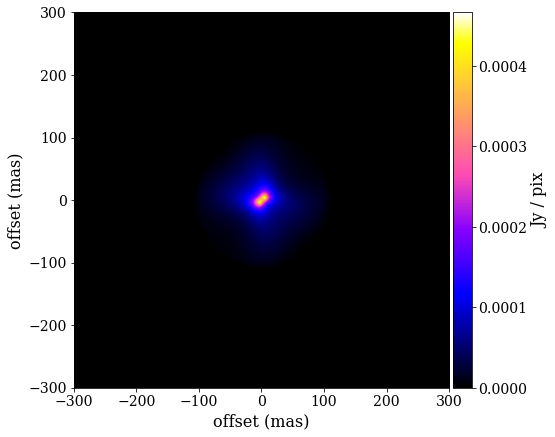

In [20]:
print("BEFORE")
diagnostics(img)
img.changeFOV('600 mas')
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');
print("AFTER")
diagnostics(img)

Embedding the model image in a larger field does change the number of pixels and the FOV, but does not change the pixel scale. It also does not change the total flux density in the image because the new pixels in the outer areas of the new image are all zero.

Note that the FOV and pixelscale are sometimes adjusted slightly from the requested values, such that the image dimensions (number of pixels) are always odd. This is so because the central source, the AGN, must always be within a single central pixel. In the example above, the requested target FOV was 600 mas, but the adjusted final value is 600.3 mas.

Let's now try to "zoom in" by cropping into the image.

BEFORE
-----------
npix = 667
pixelscale = 0.9 mas
FOV = 600.3000000000001 mas
total flux density = 1.4999999749660493 Jy
-----------

ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None
AFTER
-----------
npix = 55
pixelscale = 0.9 mas
FOV = 49.5 mas
total flux density = 0.4572456067800522 Jy
-----------



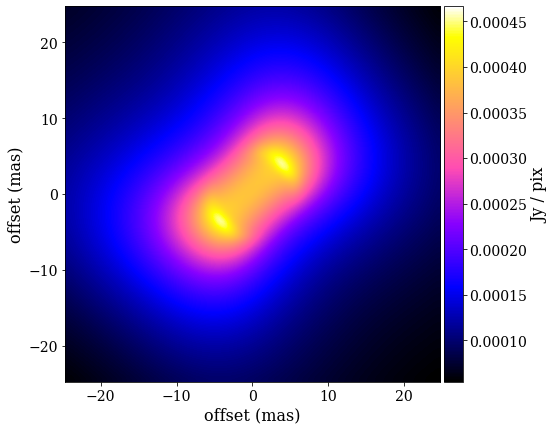

In [21]:
print("BEFORE")
diagnostics(img)
img.changeFOV('50 mas')
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');
print("AFTER")
diagnostics(img)

Cropping deep into the image removed changed the number of pixels and FOV again, but the pixel scale remained unchanged. Cropping also removed a fraction of the total flux density.

<a class="anchor" id="rot"></a>
## Image rotation

If a position angle was given when the `Source` object (in this notebooks we called it `agn`) was instantiatied, all images created from the `Source` instance will be rotated by that PA. It is possible to change the rotation of the image.

Let's create a new image again:

In [22]:
img = agn(vec)
print(img.pa)

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
rawimage.min():  0.0
Rotated image (see self.data) by 43.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
43.0 deg


And plot it:

ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None


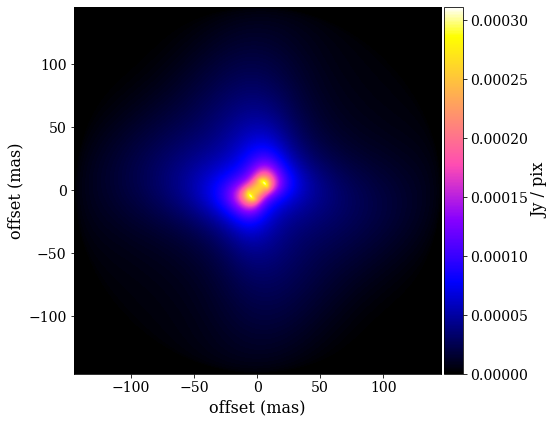

In [23]:
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');

Now let's rotate it 43 degrees clockwise (N through W):

In [24]:
img.rotate('-43 deg')

Rotated image (see self.data) by -43 deg in direction 'NE'.


ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None


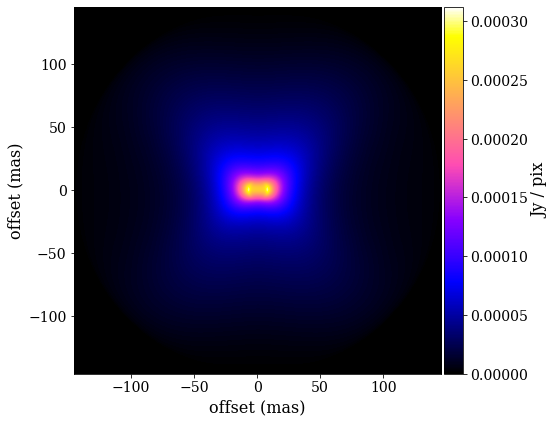

In [25]:
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');

And now let's rotate it 90 degrees counter-clockwise (N through E):

In [26]:
img.rotate('90 deg')

Rotated image (see self.data) by 90 deg in direction 'NE'.


ny,nx =  1 1
contours before arrayify:  None
contours before arrayify:  [[None]]
Plotting panel (0,0)
contours =  None


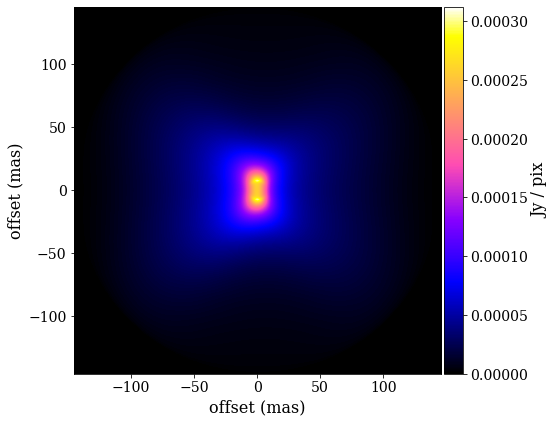

In [27]:
plotting.multiplot(img,panelsize=8,cmap='gnuplot2');

<a class="anchor" id="savefits"></a>
## Save as FITS files
You can save any images produced with HYPERCAT to FITS files.

First, save one image to a new FITS file:

In [28]:
ioops.save2fits(img,'myfile.fits')

New FITS file 'myfile.fits' created.
New (empty) primary HDU written.
Data saved as new ImageHDU.


In [29]:
fits.info('myfile.fits')

Filename: myfile.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU        35   (241, 241)   float32   


We see that the image was saved to HDU=1, and is simply a 2D array of 241x241 values. The header has 35 entries: 

In [30]:
fits.getheader('myfile.fits',ext=1)

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  241                                                  
NAXIS2  =                  241                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                121.0 / Pixel coordinate of reference point            
CRPIX2  =                121.0 / Pixel coordinate of reference point            
CDELT1  = -3.3552808069658E-07 / [deg] Coordinate increment at reference point  
CDELT2  =  3.3552808069658E-07 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

We see it contains the WCS, the model parameters, etc.

We can add other images to the same FITS file, e.g. at a different wavelength:

In [31]:
print(vec)

(40, 85, 20, 4, 0, 20, 10.0)


In [32]:
vec2 = (40,85,20,4,0,20,100)  # change wave to 100 micron
print(vec2)

(40, 85, 20, 4, 0, 20, 100)


In [33]:
img100 = agn(vec2)

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
rawimage.min():  0.0
Rotated image (see self.data) by 43.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.


In [34]:
ioops.save2fits(img100,'myfile.fits')

Existing FITS file 'myfile.fits' opened.
Data saved as new ImageHDU.


Let's check the FITS file again:fits.info('myfile.fits')

In [35]:
fits.info('myfile.fits')

Filename: myfile.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU        35   (241, 241)   float32   
  2                1 ImageHDU        35   (241, 241)   float32   


The new images was appended to the existing FITS file as a new HDU (=2). Its header is:

In [36]:
fits.getheader('myfile.fits',ext=2)

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  241                                                  
NAXIS2  =                  241                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                121.0 / Pixel coordinate of reference point            
CRPIX2  =                121.0 / Pixel coordinate of reference point            
CDELT1  = -3.3552808069658E-07 / [deg] Coordinate increment at reference point  
CDELT2  =  3.3552808069658E-07 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

And if we check the differences between the headers of HDU=1 and HDU=2

In [37]:
hdr1 = fits.getheader('myfile.fits',ext=1)
hdr2 = fits.getheader('myfile.fits',ext=2)
print(fits.HeaderDiff(hdr1,hdr2).report())

 Keyword DATE     has different values:
    a> 2021-06-13T19:54:07
     ?                   -
    b> 2021-06-13T19:54:10
     ?                  +
 Keyword WAVE     has different values:
    a> 10.0
    b> 100.0
     ?  +
 Keyword WAVE_    has different values:
    (float) a> 10.0
             ?   -
      (int) b> 100



we see that the keywords `WAVE`, `WAVE_`, and `DATE` are different, es expected.

<a class="anchor" id="info"></a>
## Further information
* More information on WCS and astropy: https://docs.astropy.org/en/stable/wcs/

* For a demonstration of other capabilities of HYPERCAT, please check out the various other notebooks in: https://github.com/rnikutta/hypercat/tree/master/examples/